## Step 1: Pull the dataset and train a simple CNN model for classification
Same as Week 3 demonstration

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import Dataset

/opt/anaconda3/envs/huggingface/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [4]:
dataset = load_dataset("fashion_mnist")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class FashionDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

full_train_dataset = FashionDataset(dataset['train'], transform=transform)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
test_dataset = FashionDataset(dataset['test'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

Using the latest cached version of the dataset since fashion_mnist couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'fashion_mnist' at /Users/kanxuanhe/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/0.0.0/531be5e2ccc9dba0c201ad3ae567a4f3d16ecdd2 (last modified on Tue Jun 24 11:51:17 2025).


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
# Set up training configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

# CrossEntropyLoss applies softmax + loss in one step
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Add a global list to store training loss per epoch
train_losses = []

# Model training function
def train_model(num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

In [7]:
# Train the model
train_model()

Epoch 1, Loss: 0.4655
Epoch 2, Loss: 0.2889
Epoch 3, Loss: 0.2433
Epoch 4, Loss: 0.2082
Epoch 5, Loss: 0.1802


## Step 2: Register hooks in the layers to capture the feature map

In [8]:
# Register a hook to capture the feature map of the second convolutional layer (self.model[3])
feature_maps = {}
def hook_fn_conv1(module, input, output):
    feature_maps['conv1'] = output.detach()

def hook_fn_conv2(module, input, output):
    feature_maps['conv2'] = output.detach()

hook_handle1 = model.model[0].register_forward_hook(hook_fn_conv1)
hook_handle2 = model.model[3].register_forward_hook(hook_fn_conv2)

## Step 3: Forward with a singe img and visualize the feature map

In [9]:
# Run a forward pass on a single test image to trigger the hook and capture the feature map
model.eval()
with torch.no_grad():
    img, label = test_dataset[10]
    img_batch = img.unsqueeze(0).to(device)  # Add batch dimension and send to device
    output = model(img_batch)  # Forward pass (output ignored here)

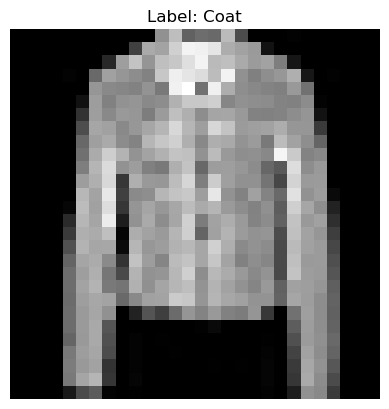

In [10]:
class_names = dataset['train'].features['label'].names

def imshow(img_tensor):
    img = img_tensor * 0.5 + 0.5 
    img = img.clamp(0, 1)
    np_img = img.squeeze().cpu().numpy()
    plt.imshow(np_img, cmap='gray')
    plt.axis('off')

plt.figure()
imshow(img)
plt.title(f'Label: {class_names[label]}')
plt.show()

In [11]:
def visualize_feature_maps(features, mode='individual'):
    """
    Visualize feature maps with options for individual channels or aggregated map.
    
    Args:
        features: Tensor of shape [batch, channels, height, width]
        mode: 'individual' to plot each channel separately (default)
              'mean' to plot mean aggregated map over channels
              'max' to plot max aggregated map over channels
    """
    if mode == 'individual':
        num_channels = features.shape[1]
        cols = 8
        rows = (num_channels + cols - 1) // cols
        plt.figure(figsize=(cols*2, rows*2))
        for i in range(num_channels):
            plt.subplot(rows, cols, i+1)
            plt.imshow(features[0, i].cpu(), cmap='viridis')
            plt.axis('off')
            plt.title(f'ch{i}')
        plt.suptitle('Feature maps of conv layer (individual channels)')
        plt.show()
    
    elif mode == 'mean':
        aggregated_map = features.mean(dim=1)[0].cpu()  # Mean over channels
        plt.figure(figsize=(6,6))
        plt.imshow(aggregated_map, cmap='viridis')
        plt.colorbar()
        plt.title('Mean aggregated feature map of conv layer')
        plt.axis('off')
        plt.show()
    
    elif mode == 'max':
        aggregated_map = features.max(dim=1)[0][0].cpu()  # Max over channels
        plt.figure(figsize=(6,6))
        plt.imshow(aggregated_map, cmap='viridis')
        plt.colorbar()
        plt.title('Max aggregated feature map of conv layer')
        plt.axis('off')
        plt.show()

    else:
        raise ValueError("Invalid mode! Choose from 'individual', 'mean', or 'max'.")

Feature map of Conv1 Layer (Individual channels)


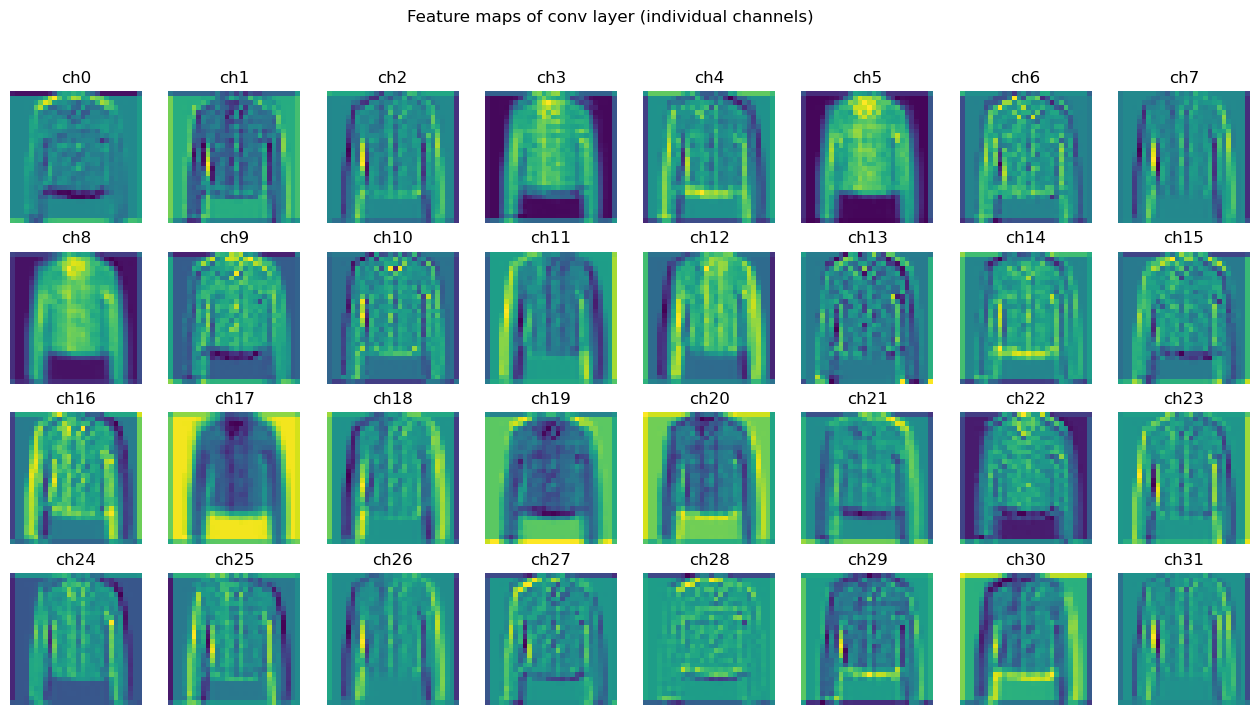

Feature map of Conv2 Layer (Individual channels)


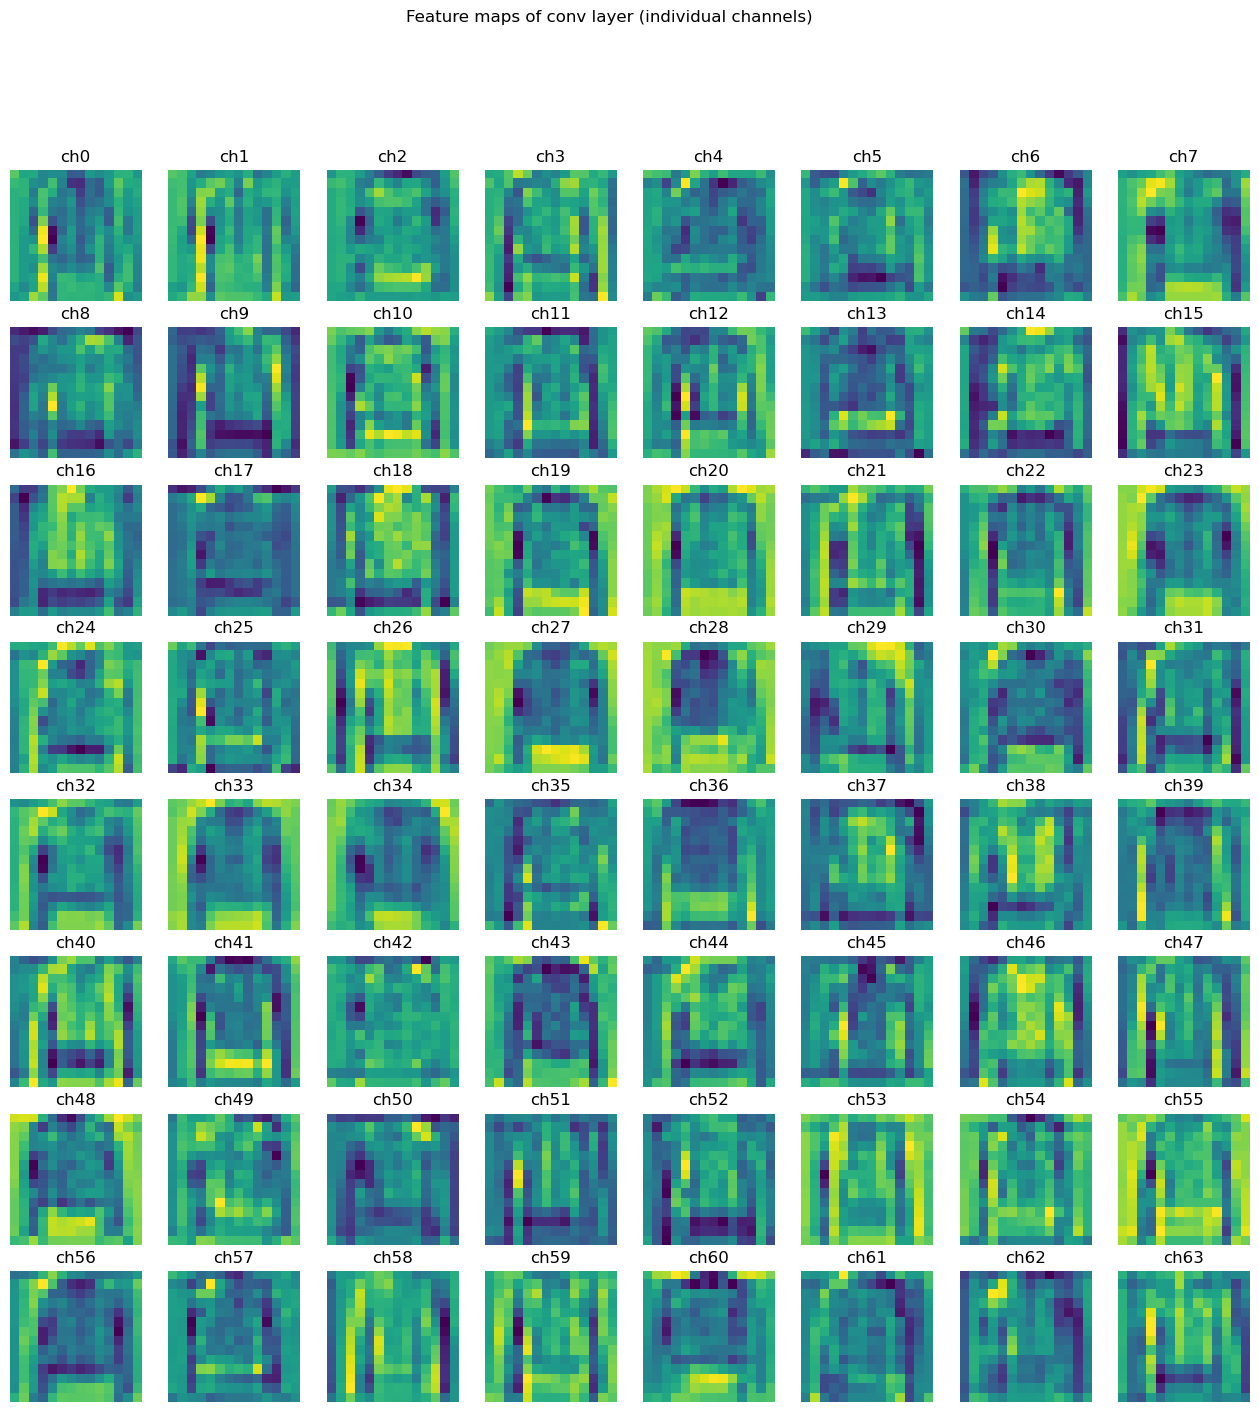

In [12]:
# Visualize the feature maps collected by the hook
print("Feature map of Conv1 Layer (Individual channels)")
visualize_feature_maps(feature_maps['conv1'], mode='individual')
print("Feature map of Conv2 Layer (Individual channels)")
visualize_feature_maps(feature_maps['conv2'], mode='individual')

# Remove the hook after visualization to avoid side effects
hook_handle1.remove()
hook_handle2.remove()

Feature map of Conv1 Layer (Mean Aggregated Map)


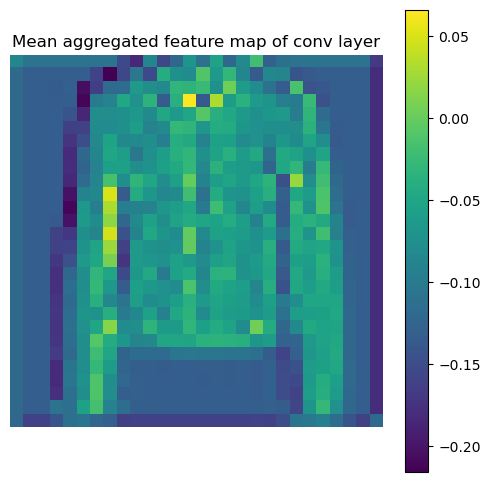

Feature map of Conv2 Layer (Mean Aggregated Map)


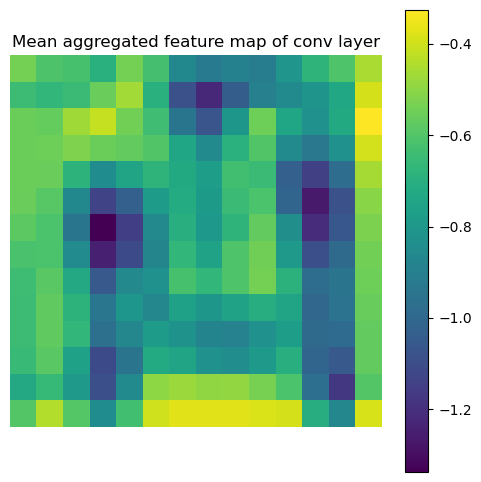

In [13]:
# Visualize the feature maps collected by the hook
print("Feature map of Conv1 Layer (Mean Aggregated Map)")
visualize_feature_maps(feature_maps['conv1'], mode='mean')
print("Feature map of Conv2 Layer (Mean Aggregated Map)")
visualize_feature_maps(feature_maps['conv2'], mode='mean')

# Remove the hook after visualization to avoid side effects
hook_handle1.remove()
hook_handle2.remove()

Feature map of Conv1 Layer (Max Aggregated Map)


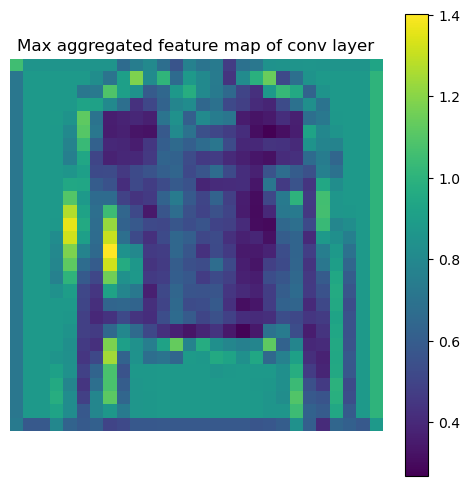

Feature map of Conv2 Layer (Max Aggregated Map)


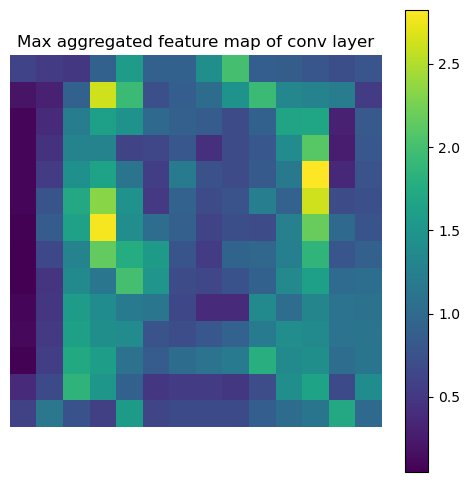

In [14]:
# Visualize the feature maps collected by the hook
print("Feature map of Conv1 Layer (Max Aggregated Map)")
visualize_feature_maps(feature_maps['conv1'], mode='max')
print("Feature map of Conv2 Layer (Max Aggregated Map)")
visualize_feature_maps(feature_maps['conv2'], mode='max')

# Remove the hook after visualization to avoid side effects
hook_handle1.remove()
hook_handle2.remove()

## Step 4: Compare feature maps of images with different labels

In [15]:
def visualize_feature_maps_both_layers(model, dataset, label_names, samples_per_class=1, device='cpu'):
    """
    Visualize input images with mean/max aggregated feature maps from conv1 and conv2 layers.

    Args:
        model: trained model with registered hooks for 'conv1' and 'conv2'
        dataset: test dataset (e.g., test_dataset)
        label_names: list of class names (length 10)
        samples_per_class: number of samples to visualize per class
        device: torch device
    """
    model.eval()
    shown = {i: 0 for i in range(10)}
    selected = []

    # Select samples_per_class per label
    for img, label in dataset:
        if shown[label] < samples_per_class:
            selected.append((img, label))
            shown[label] += 1
        if sum(shown.values()) >= 10 * samples_per_class:
            break

    num_samples = len(selected)
    plt.figure(figsize=(15, num_samples * 3))

    for i, (img, label) in enumerate(selected):
        img_batch = img.unsqueeze(0).to(device)

        # Forward pass to trigger hooks
        with torch.no_grad():
            _ = model(img_batch)

        # --- Original image ---
        plt.subplot(num_samples, 5, i*5 + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f'Label: {label_names[label]}')
        plt.axis('off')

        # --- Conv1 mean ---
        mean_map1 = feature_maps['conv1'].mean(dim=1)[0].cpu()
        plt.subplot(num_samples, 5, i*5 + 2)
        plt.imshow(mean_map1, cmap='viridis')
        plt.title('Conv1 Mean')
        plt.axis('off')

        # --- Conv1 max ---
        max_map1 = feature_maps['conv1'].max(dim=1)[0][0].cpu()
        plt.subplot(num_samples, 5, i*5 + 3)
        plt.imshow(max_map1, cmap='viridis')
        plt.title('Conv1 Max')
        plt.axis('off')

        # --- Conv2 mean ---
        mean_map2 = feature_maps['conv2'].mean(dim=1)[0].cpu()
        plt.subplot(num_samples, 5, i*5 + 4)
        plt.imshow(mean_map2, cmap='viridis')
        plt.title('Conv2 Mean')
        plt.axis('off')

        # --- Conv2 max ---
        max_map2 = feature_maps['conv2'].max(dim=1)[0][0].cpu()
        plt.subplot(num_samples, 5, i*5 + 5)
        plt.imshow(max_map2, cmap='viridis')
        plt.title('Conv2 Max')
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle('Feature Map Visualization: Original + Conv1/Conv2 Aggregations', fontsize=16, y=1.03)
    plt.savefig('feature_map_comparison.png')
    plt.show()

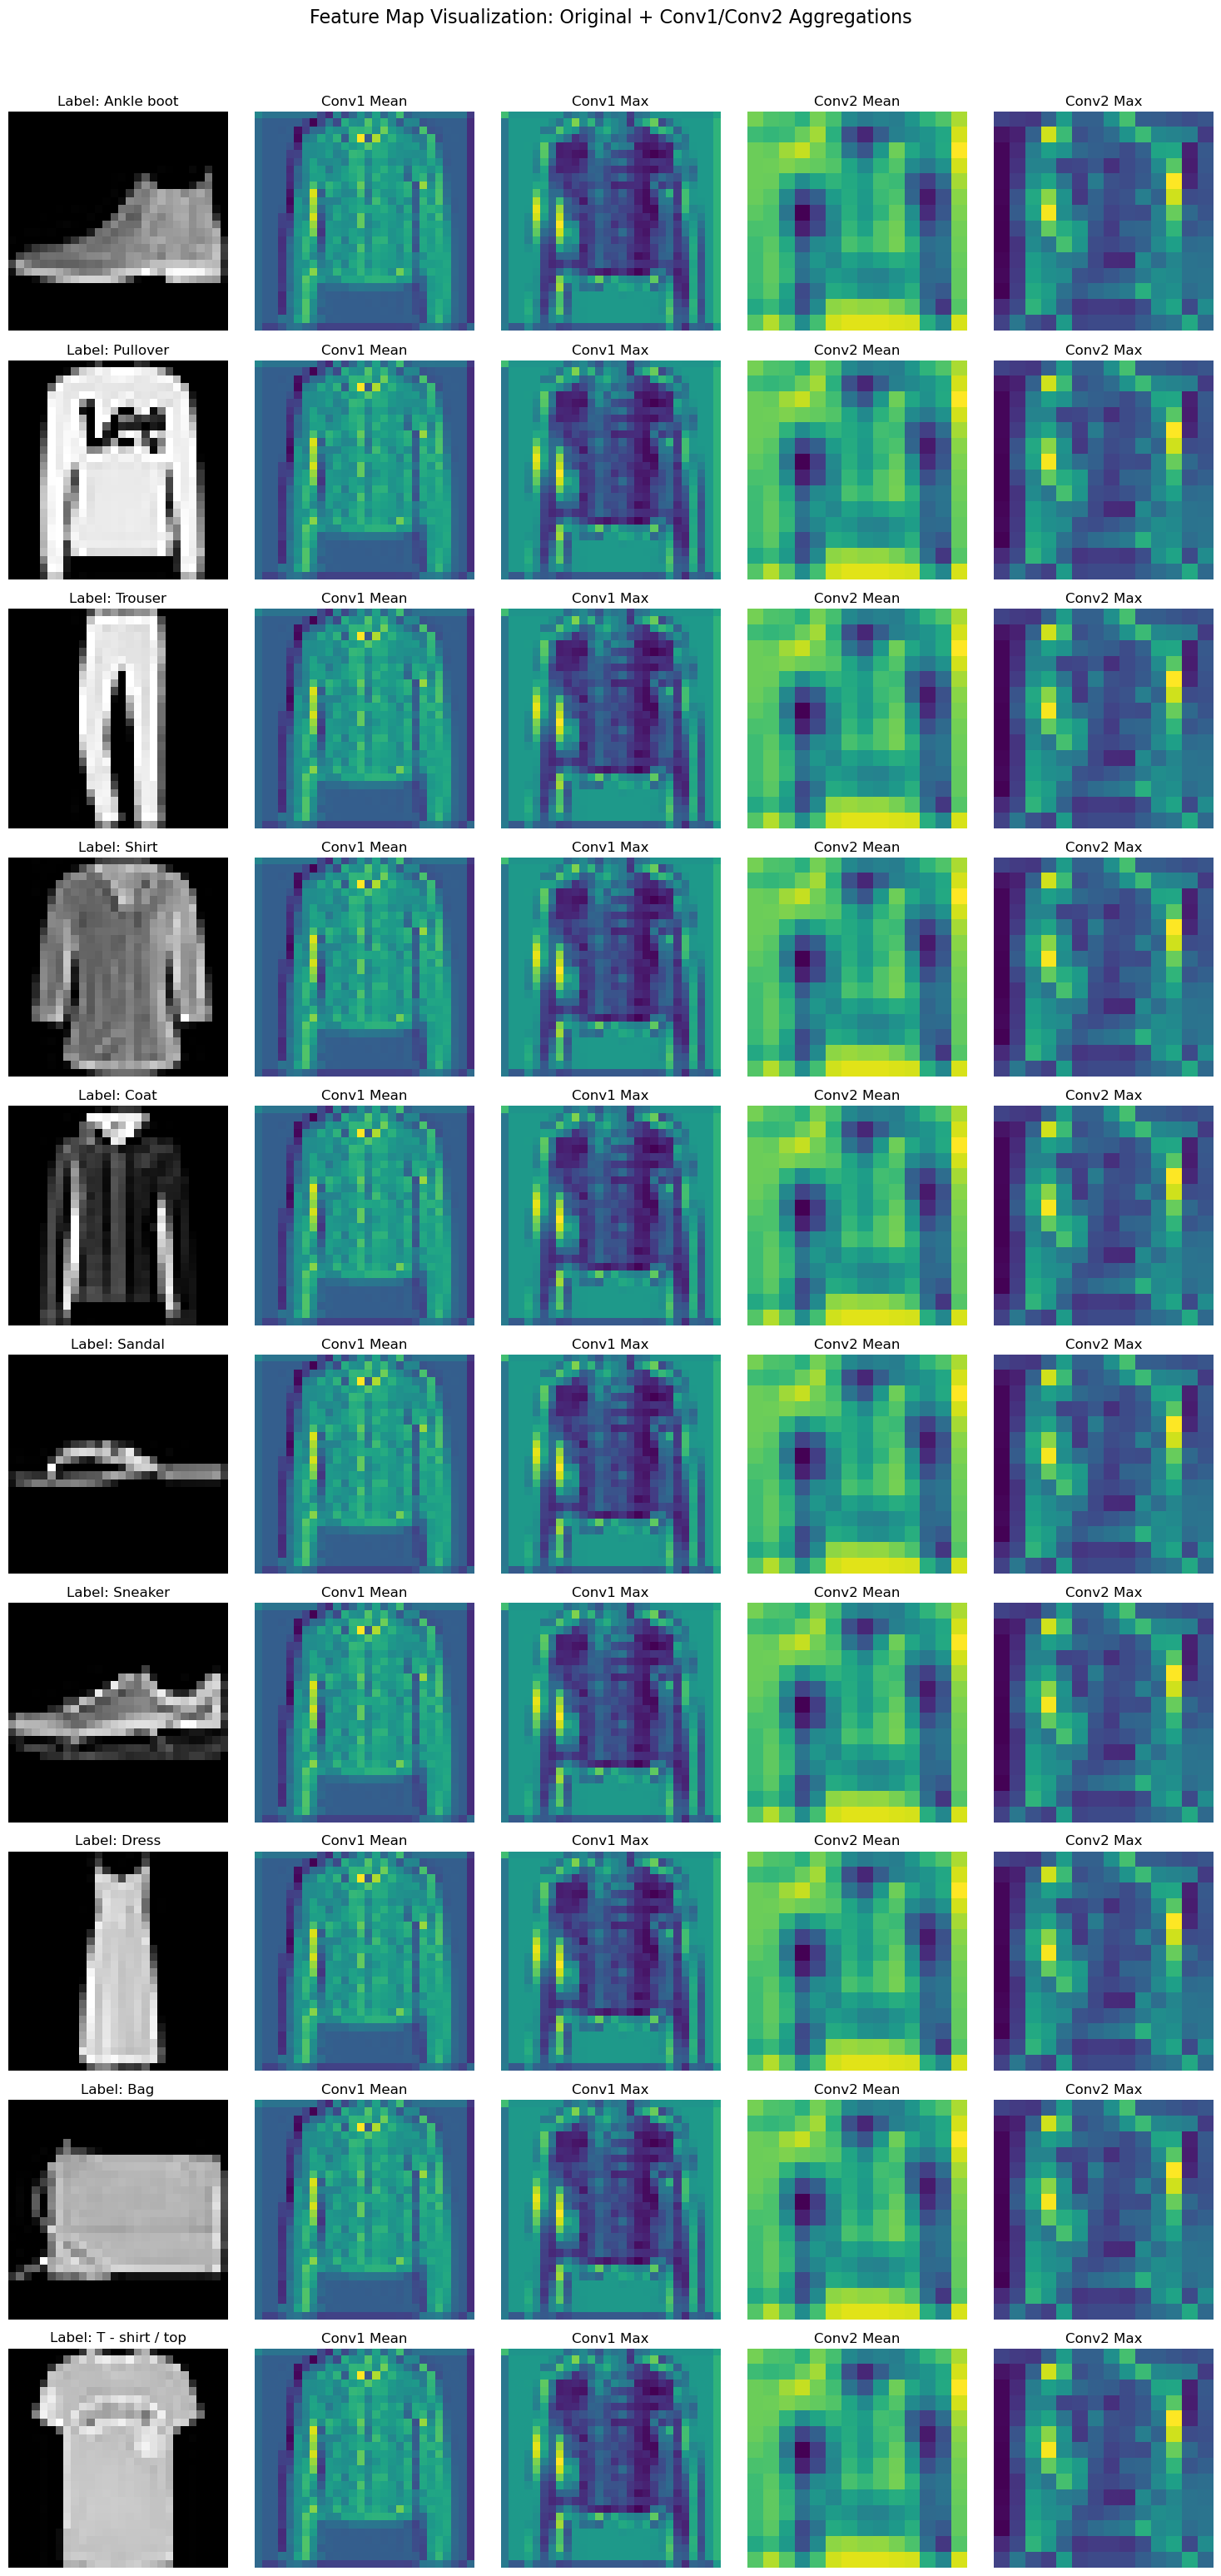

In [16]:
label_names = dataset['train'].features['label'].names
visualize_feature_maps_both_layers(model, test_dataset, label_names, samples_per_class=1, device=device)

# Remove the hook after visualization to avoid side effects
hook_handle1.remove()
hook_handle2.remove()